## Physics based parameter extraction

- Underwater Image formation model
    
    $$
    I_{c,i} = J_{c,i}*t_{c,i} + B_c^{\infty}(1-t_{c,i}) \\ t_{c,i} = e^{-\beta_c\mathbf{z}_i}
    $$
    
    - $I_c \in \real^{HW}$, represents the underwater image, subscript c denotes the index of the color channel {R,G,B}
    - $J_c$ is the original in-air image.
    - $t_{c,i}$ is the medium transmission rate
    - $\beta_c$ is the beam attenuation coefficient.
    - $\mathbf{z}_i$ is the depth
    - $B_c^\infty$ is the coefficient of ambient light causing the backscattering from the particles in water.
    
    $\beta, B$ vary depending on different water env and can be estimated using the depth estimation.
    
    - The relationship between metric depth $z_i$ and $d_i$, s and it are unknown coefficients.
    
    $$
    z_i = \frac{1}{sd_i+t}
    $$
    
    ## Parameter Estimation
    
    use parent model to correct the biased estimation of the model for more distant regions using extracted physics information from depth estimation for closer regions. 
    
    > **Require:** $d^D \in \mathbb{R}^{HW}, I_c \in \mathbb{R}^{HW}, N \in \mathbb{Z}_{++}, c \in \{G,B\}$
    **Ensure**: Pure background exists in the training images.
    1. Find farthest 15% points using $d^D$, denoted as $P^f$.
    2. Select the darkest 20% points using $I_c$ from $P^f$, denote as $P_c^d$. Compute $\hat{B}^\infty_c$= median($I_{c,i}$) for $i\in P_c^d$.
    3. Select N darkest points from the closest 10% - 40% pixels on each color channel to form the set $M_c$.
    4. Solve least-squares problem to get the parameters.
    **return $\hat{\nu}_G, \hat{\nu}_B, \hat{\mu},$**  and $\hat{B}^\infty_c$
    > 
    
    The rationale for extracting the darkest points in UDCP is analogous to identifying points where $J_{c,i}$ is assumed to be close to zero and where the colour appearance on these pixels is solely due to the backscattering term.
    
    $$
    \epsilon_c = \sum_{i \in M_c} \left\| I_{c,i}  - B_{c}^\infty (1- e^{\frac{-\nu_C}{\mathbf{d_i}^D + \mu}}\right\|
    $$
    
    $\nu_c = \beta_c/s, \mu = h/s$
    
    Solve
    
    $$
    (\hat{\nu}_G, \hat{\nu}_B, \hat{\mu}, \hat{B}_c^{\infty}) = \argmin_{\nu_G, \nu_B, \mu, B_c^\infty} \sum_{c\in\{G,B\}}\epsilon_c
    $$
    
    repeat, exclude the regionds where parent model’s estimation is inaccurate while maximizing the utilisation of the largest point. 
    
    Select N_2 darkest points from the selected regions to construct the set M_c2 and adress the least-squared problem, use $\hat{B}_c^\infty$
    
    N_1 = 500 , N_2 = 200

## implementing parameter estimation alg

In [510]:
import numpy as np
from scipy.optimize import minimize
from depth_estimation_fns import overlay_color, display_mask_as_image
from PIL import Image
from scipy.spatial.distance import cdist

def find_farthest_points(d_D, percentage=15):
    # 15% of the points are farthest
    num_samples = d_D.shape[0]
    num_points = int(num_samples * (percentage) / 100)
    farthest_indices = np.argsort(d_D)[:num_points]
    return farthest_indices

def select_darkest_points(I, farthest_indices, percentage=20):
    # get darkest points from the farthest points per channel
    num_samples = len(farthest_indices)
    num_points = int(num_samples * percentage / 100)
    # get the darkest points from each channel
    darkest_indices = []
    for i in range(I.shape[0]):
        sorted_indices = farthest_indices[np.argsort(I[i, farthest_indices])]
        darkest_indices.append(sorted_indices[:num_points])
    return np.array(darkest_indices)

def compute_B_infty(I, darkest_indices):
    # Compute B_infty for each channel
    B_infty = np.zeros(I.shape[0])
    for i in range(I.shape[0]):
        B_infty[i] = np.median(I[i, darkest_indices[i]])
    return B_infty

def select_closest_points_within_range(d, percentage_range=(10, 40)):
    # Compute distance percentiles
    high_percentile = np.percentile(d, 100-percentage_range[0])
    low_percentile = np.percentile(d, 100-percentage_range[1])

    # Determine the range of indices within the percentile range
    within_range_indices = np.where((d >= low_percentile) & (d <= high_percentile))[0]

    return within_range_indices


# def find_set_M(I, d, percentage_range=(10, 40), num_points=10):
#     # Find indices within the specified range
#     points_within_range = select_closest_points_within_range(d, percentage_range)
#     # find the N darkest points within the range
#     sorted_indices_G = np.argsort(I[0, points_within_range], axis=0)    
#     sorted_indices_B = np.argsort(I[1, points_within_range], axis=0)
#     interval = max(1, I.shape[1] // num_points)  # Ensure at least one pixel per interval
#     selected_indices_G = points_within_range[sorted_indices_G[::interval][:num_points]]
#     selected_indices_B = points_within_range[sorted_indices_B[::interval][:num_points]]
#     selected_indices = np.array([selected_indices_G, selected_indices_B])
#     return selected_indices
# def find_set_M(I, d, percentage_range=(10, 40), num_points=10):
#     # Find indices within the specified range
#     points_within_range = select_closest_points_within_range(d, percentage_range)
    
#     # find the N darkest points within the range for each channel
#     num_channels = I.shape[0]
#     selected_indices = []

#     for channel in range(num_channels):
#         sorted_indices = np.argsort(I[channel, points_within_range], axis=0)
#         interval = max(1, len(points_within_range) // num_points)  # Ensure at least one pixel per interval
#         selected_indices_channel = points_within_range[sorted_indices[:num_points * interval:interval]]
#         selected_indices.append(selected_indices_channel)

#     return np.array(selected_indices)

def find_set_M(I, d_D, N, cluster_radius=48, cluster_size=12, M_range=(10, 60), default_image_dim=(576, 384)):
    num_channels = I.shape[0]
    reshaped_I = I.reshape(num_channels, default_image_dim[1], default_image_dim[0])
    
    selected_indices = []
    for channel in range(num_channels):
        # Sort the pixel values for the current channel 
        darkest_indices = np.unravel_index(np.argsort(reshaped_I[channel].flatten()), reshaped_I[channel].shape)
        # Keep track of selected pixels 
        selected_pixels = [darkest_indices[0][0] * reshaped_I.shape[2] + darkest_indices[1][0]]
        
        selected_coords = np.array([[darkest_indices[0][0], darkest_indices[1][0]]])

        # Keep track of the number of pixels selected within max_distance for each pixel
        pixels_within_distance_count = np.zeros_like(reshaped_I[channel], dtype=int)
        _percentile_h = 100 - M_range[1] 
        _percentile_l = 100 - M_range[0] 
        indx_wtih_d_D_max = np.where(d_D[channel]!=0.0)
        _cluster_radius = cluster_radius
        _cluster_size = cluster_size
        while len(selected_pixels) < N:
            # Calculate percentiles 
            # print("Percentile", _percentile_l, _percentile_h)
            percentile_l = np.percentile(d_D[channel][indx_wtih_d_D_max], _percentile_l)
            percentile_h = np.percentile(d_D[channel][indx_wtih_d_D_max], _percentile_h)
            # print("Percentile", percentile_l, percentile_h)
            # Iterate through remaining pixels to check distance
            for i in range(1, len(darkest_indices[0])):
                current_row, current_col = darkest_indices[0][i], darkest_indices[1][i]
                current_pixel = current_row * reshaped_I.shape[2] + current_col
                current_coord = (current_row, current_col)

                if current_pixel in selected_pixels or I[channel, current_pixel] == 1.0:
                    continue
                # Calculate Euclidean distances between current pixel and selected pixels
                distances = np.sqrt(np.sum((selected_coords - current_coord) ** 2, axis=1))

                # Count the number of pixels within max_distance
                pixels_within_distance = np.sum(distances <= _cluster_radius)

                is_valid_d_D = (d_D[channel, current_pixel]>percentile_h) and (d_D[channel, current_pixel]<percentile_l)
                
                # Check if the number of pixels within max_distance exceeds cluster_size
                if is_valid_d_D and pixels_within_distance <= _cluster_size:
                    selected_pixels.append(current_pixel)
                    selected_coords = np.append(selected_coords, [current_coord], axis=0)
                    
                    # Update the count of pixels selected within max_distance for each pixel
                    pixels_within_distance_count[current_row, current_col] = pixels_within_distance

                    # Break if N pixels are selected
                    if len(selected_pixels) == N:
                        # remove the outliers from the selected pixels
                        M = np.array(selected_pixels)
                        x = np.exp(-1/(1+d_D[channel, M]))
                        lingress = np.polyfit(x, I[channel, M], 1)
                        # find the residuals
                        residuals = I[channel, M] - (lingress[0]*x + lingress[1])
                        # find the outliers
                        not_outliers = np.where(residuals < 0.08)
                        selected_pixels = M[not_outliers].tolist()
                        if len(selected_pixels) == N:
                            break
            if len(selected_pixels) < N:
                print(f"Altering params for channel: {channel}, selected: {len(selected_pixels)}/{N}")
                if _percentile_h == 1 and _percentile_l == 98:
                    if len(selected_pixels) < N:
                        print("Increasing Cluster size")
                        if _cluster_size == cluster_size*4:
                            print("Decreasing cluster max radial")
                            if _cluster_radius == (cluster_radius)//2:
                                print("Could not find enough pixels")
                                # find the selected pixels not in the darkest indices
                                M = np.array(selected_pixels)
                                darkest_indices_flatten = darkest_indices[0] * reshaped_I.shape[2] + darkest_indices[1]
                                not_in_darkest_indices = np.setdiff1d(darkest_indices_flatten, M)
                                print(not_in_darkest_indices.shape)
                                # append the remaining pixels from the darkest indices to get N pixels
                                selected_pixels = np.append(M, not_in_darkest_indices[:N-len(selected_pixels)]).tolist()
                                print(len(selected_indices))
                                break
                            _cluster_radius = max(_cluster_radius-4, (cluster_radius//2))
                        _cluster_size = min((cluster_size*4), _cluster_size+2)
                _percentile_h  = max(1, _percentile_h - 4)
                _percentile_l  = min(98, _percentile_l + 2)
                print(f"percentile_h: {_percentile_h}, percentile_l: {_percentile_l}, cluster_radius: {_cluster_radius}, cluster_size: {_cluster_size}")
                

            

        selected_indices.append(selected_pixels)

    return np.array(selected_indices)

def find_set_M_fast(I, d, N):
    num_channels = I.shape[0]
    

def find_set_M_evenly(I, N):
    # Sort pixels along each channel axis-wise
    sorted_indices = np.argsort(I, axis=1)

    # Get the indices of the smallest N points for each channel
    selected_indices = sorted_indices[:, :N]

    return selected_indices


def solve_optimisation_problem(d, I, initial_v=[1, 1], initial_mu=1, initial_B_infty=[1, 1], keep_B_infty=False):
    """
    Optimize parameters nu, mu, and B_infty for both G and B.

    Parameters:
    d: list
        List of distances
    I: list
        List of arrays for I_G and I_B.
    initial_v: list, optional
        Initial guess for the nu. Default is [1, 1].
    initial_mu: float, optional
        Initial guess for the mu. Default is 1.
    initial_B_infty: list, optional
        Initial guess for the B_infty. Default is [1, 1].

    Returns:
    hat_nu: numpy array
        Optimized values of nu for G and B.
    hat_mu: float
        Optimized value of mu.
    hat_B_infty: numpy array
        Optimized values of B_infty for G and B.
    """
    num_channels = I.shape[0]
    # Vectorized objective function
    def objective(params):
        nu = params[:num_channels]
        mu = params[num_channels]
        if keep_B_infty:
            B_infty = initial_B_infty
        else:
            B_infty = params[num_channels + 1:]
        # Calculate predicted values
        total_epsilon = np.sum(np.abs(I - B_infty[:, np.newaxis] * (1 - np.exp(-nu[:, np.newaxis] / (d + mu))))**2)
        return total_epsilon
    

    initial_guess = np.concatenate((initial_v, [initial_mu], initial_B_infty))
    result = minimize(objective, initial_guess, method='BFGS')
    hat_nu = result.x[:num_channels]
    hat_mu = result.x[num_channels]
    if keep_B_infty:
        hat_B_infty = initial_B_infty
    else:
        hat_B_infty = result.x[num_channels + 1:]
    return hat_nu, hat_mu, hat_B_infty



def select_elements_with_indices(I, M):
    # Create an array of indices corresponding to the rows of I
    row_indices = np.arange(len(M))
    # Use advanced indexing to select elements from I using indices in M
    I_new = I[row_indices[:, None], M]
    return I_new

def find_underwater_parameters(d_D, I, N=10, M_range=(10, 60), initial_v=[1, 1], 
                               initial_mu=1, initial_B_infty=[1, 1], keep_B_infty=False, 
                               default_image_dim=(576, 384), cluster_radius=48, cluster_size=12, is_verbose=False):
    # Step 3: Compute B_infty for each channel
    darkest_indices = None
    if not keep_B_infty:
        # Step 1: Find farthest 15% points
        farthest_indices = find_farthest_points(d_D[0])
        # Step 2: Select darkest 20% points per channel
        darkest_indices = select_darkest_points(I, farthest_indices)
        initial_B_infty = compute_B_infty(I, darkest_indices)
    
    # Step 4: Select N darkest points from each channel
    # M = find_set_M(I, d_D, M_range, N)
    M = find_set_M(I=I, d_D=d_D, N=N,M_range=M_range, default_image_dim=default_image_dim, 
                   cluster_radius=cluster_radius, cluster_size=cluster_size)
   # Select elements from I using indices in M

    I_new = select_elements_with_indices(I, M)
    d_new = select_elements_with_indices(d_D, M)

    # Step 5: Solve least-squares problem
    hat_nu, hat_mu, hat_B_infty = solve_optimisation_problem(d_new, I_new, initial_v=initial_v, initial_mu=initial_mu,
                                                             initial_B_infty=initial_B_infty, keep_B_infty=keep_B_infty)
    
    return hat_nu, hat_mu, hat_B_infty, darkest_indices, M
    

## random data test

Percentile 90 40
Percentile 0.9000004521143127 0.4000027126858755
Increasing distance range 0 404
Percentile 92 38
Percentile 0.92000036169145 0.380002803108738
Increasing distance range 0 434
Percentile 94 36
Percentile 0.9400002712685875 0.3600028935316006
Increasing distance range 0 468
Percentile 96 34
Percentile 0.960000180845725 0.34000298395446305
Increasing distance range 0 456
Percentile 98 32
Percentile 0.9800000904228624 0.32000307437732556
Increasing distance range 0 490
Percentile 98 30
Percentile 0.9800000904228624 0.300003164800188
Increasing distance range 0 499
Percentile 98 28
Percentile 0.9800000904228624 0.28000325522305064
Percentile 90 40
Percentile 0.9000004521143127 0.4000027126858755
Increasing distance range 1 403
Percentile 92 38
Percentile 0.92000036169145 0.380002803108738
Increasing distance range 1 426
Percentile 94 36
Percentile 0.9400002712685875 0.3600028935316006
Increasing distance range 1 453
Percentile 96 34
Percentile 0.960000180845725 0.340002983

C:\Users\mukul\AppData\Local\Temp\ipykernel_25264\1744278825.py:200: RuntimeWarning: overflow encountered in exp
  total_epsilon = np.sum(np.abs(I - B_infty[:, np.newaxis] * (1 - np.exp(-nu[:, np.newaxis] / (d + mu)))))
d:\mukul\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\mukul\AppData\Local\Temp\ipykernel_25264\1744278825.py:200: RuntimeWarning: overflow encountered in exp
  total_epsilon = np.sum(np.abs(I - B_infty[:, np.newaxis] * (1 - np.exp(-nu[:, np.newaxis] / (d + mu)))))


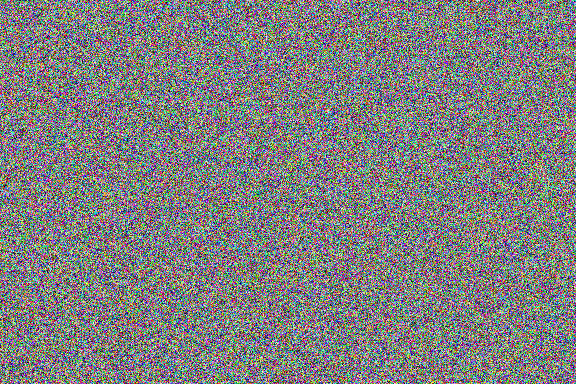

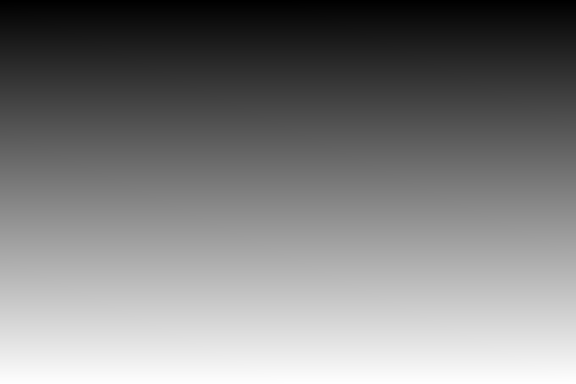

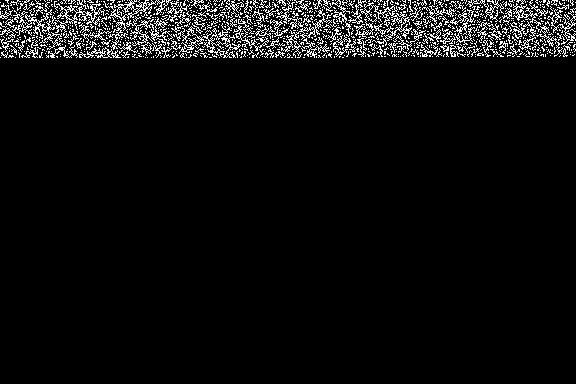

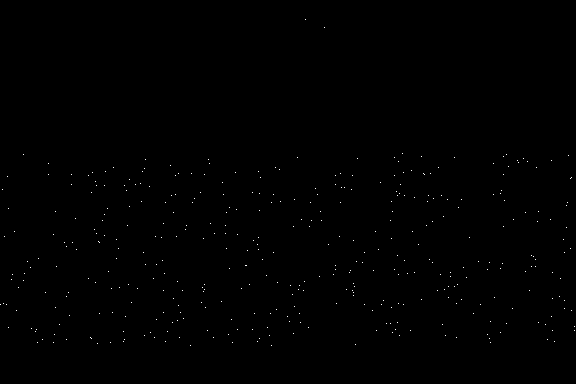

In [338]:
# Sample data
H = 576
W = 384
num_samples = H*W
n_channels = 3
# Generate d_D
d_D = np.arange(num_samples)
d_D = d_D / np.max(d_D)

random_image = np.random.rand(W, H, n_channels)
I = random_image.reshape(n_channels, -1)[1:,:] # Remove the first channel
N_1 = 500
N_2 = 200
d_D = np.array([d_D]*2)
hat_nu, hat_mu, hat_B_infty, darkest_indices, M = find_underwater_parameters(d_D, I, N=N_1)
print("Optimized Parameters:")
print("hat_nu:", hat_nu)
print("hat_mu:", hat_mu)
print("hat_B_infty:", hat_B_infty)


hat_nu, hat_mu, hat_B_infty, darkest_indices_none, M = find_underwater_parameters(d_D, I, N=N_2, initial_v=hat_nu, initial_mu=hat_mu, 
                                                         initial_B_infty=hat_B_infty, keep_B_infty=True)
                                                
print("2nd run Optimized Parameters:")
print("hat_nu:", hat_nu)
print("hat_mu:", hat_mu)
print("hat_B_infty:", hat_B_infty)


random_image = (random_image*255).astype(np.uint8)
depth_image = (d_D[0]*255).astype(np.uint8).reshape(W, H)

# create masks for the darkest points
darkest_mask = np.zeros(W*H, dtype=bool)
darkest_mask[darkest_indices] = True
darkest_mask = darkest_mask.reshape(W, H)
# create masks for  M set
M_mask = np.zeros(W*H, dtype=bool)
M_mask[M] = True
M_mask = M_mask.reshape(W, H)


display(Image.fromarray(random_image))
display(Image.fromarray(depth_image))
display_mask_as_image(darkest_mask)
display_mask_as_image(M_mask)

## image test

In [523]:
import numpy as np
import cv2 
from PIL import Image
import tifffile as tiff
from typing import Tuple
from depth_estimation_fns import open_image, preprocess_image, predict_depth, post_process_depth, get_model_image_processor_pair, display_depth, default_image_dim, make_image_grid, return_mask_as_image

#raw_image_path = "Datasets/SeaThruNeRF/JapaneseGradens-RedSea/images_wb/MTN_1098.png"
raw_image_path = "Datasets/SeaThruNeRF/IUI3-RedSea/images_wb/MTN_5930.png"
# raw_image_path = "Datasets/SeaThruNeRF/Curasao/images_wb/MTN_1293.png"
actual_depth_path = "Datasets/SeaThru/D5/depth/depthLFT_3402.tif"
model_name = "depth_anything"
model_path =  "nielsr/depth-anything-small"
device = "cuda"


def _open_png_image(path: str, img_dim: Tuple[int, int]) -> Image.Image:
    """
    Open a PNG image from the given path.

    Parameters:
        path (str): Path to the PNG image file.
        img_dim (Tuple[int, int]): Dimensions to resize the image.

    Returns:
        Image.Image: PIL Image object representing the image.
    """
    # if img_dim is None:
    #     img_dim = self.img_dim
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, img_dim, interpolation=cv2.INTER_CUBIC)
    image = Image.fromarray((image).astype(np.uint8))
    return image
# open raw_image png
raw_image = _open_png_image(raw_image_path, default_image_dim)


model, image_processor = get_model_image_processor_pair(model_name, model_path, device)
# raw_image, actual_depth = open_image(path=raw_image_path, depth_path=actual_depth_path, 
#                                         result_ground_truth_image_path="Results/parameter_estimation_results/actual_depth.png", 
#                                         img_dim=default_image_dim, save_ground_truth=False, display=False)
inputs = preprocess_image(image_processor=image_processor, image=raw_image)
predicted_depth = predict_depth(model=model, inputs=inputs)
model_output, formatted, depth_im = post_process_depth(depth=predicted_depth, image=raw_image, 
                                                       predicted_depth_path="Results/parameter_estimation_results/pred_depth.png", display=False)



Altering params for channel: 0, selected: 242/500
percentile_h: 1, percentile_l: 97, cluster_radius: 48, cluster_size: 5
Altering params for channel: 0, selected: 249/500
percentile_h: 1, percentile_l: 98, cluster_radius: 48, cluster_size: 5
Altering params for channel: 0, selected: 252/500
Increasing Cluster size
percentile_h: 1, percentile_l: 98, cluster_radius: 48, cluster_size: 7
Altering params for channel: 0, selected: 315/500
Increasing Cluster size
percentile_h: 1, percentile_l: 98, cluster_radius: 48, cluster_size: 9
Altering params for channel: 0, selected: 400/500
Increasing Cluster size
percentile_h: 1, percentile_l: 98, cluster_radius: 48, cluster_size: 11
Altering params for channel: 0, selected: 487/500
Increasing Cluster size
percentile_h: 1, percentile_l: 98, cluster_radius: 48, cluster_size: 13
Altering params for channel: 0, selected: 484/500
Increasing Cluster size
percentile_h: 1, percentile_l: 98, cluster_radius: 48, cluster_size: 15
Altering params for channel: 1

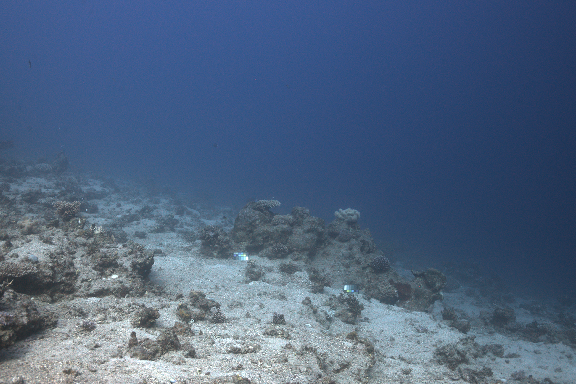

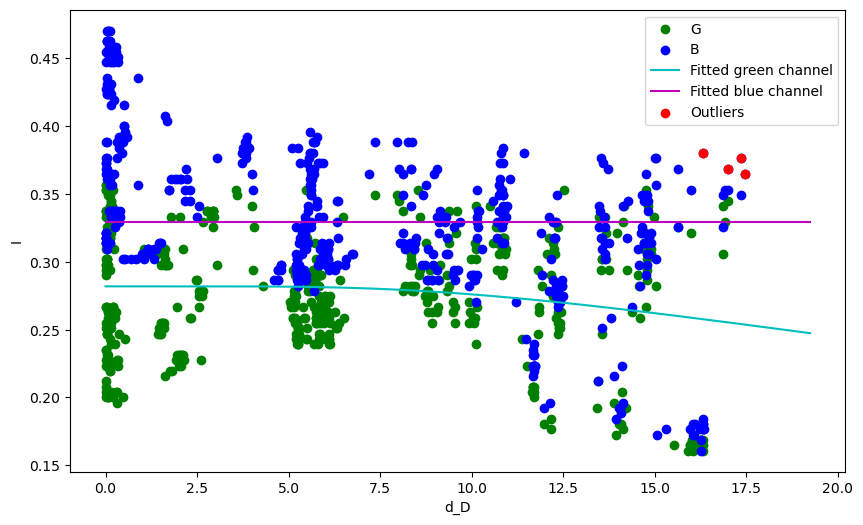

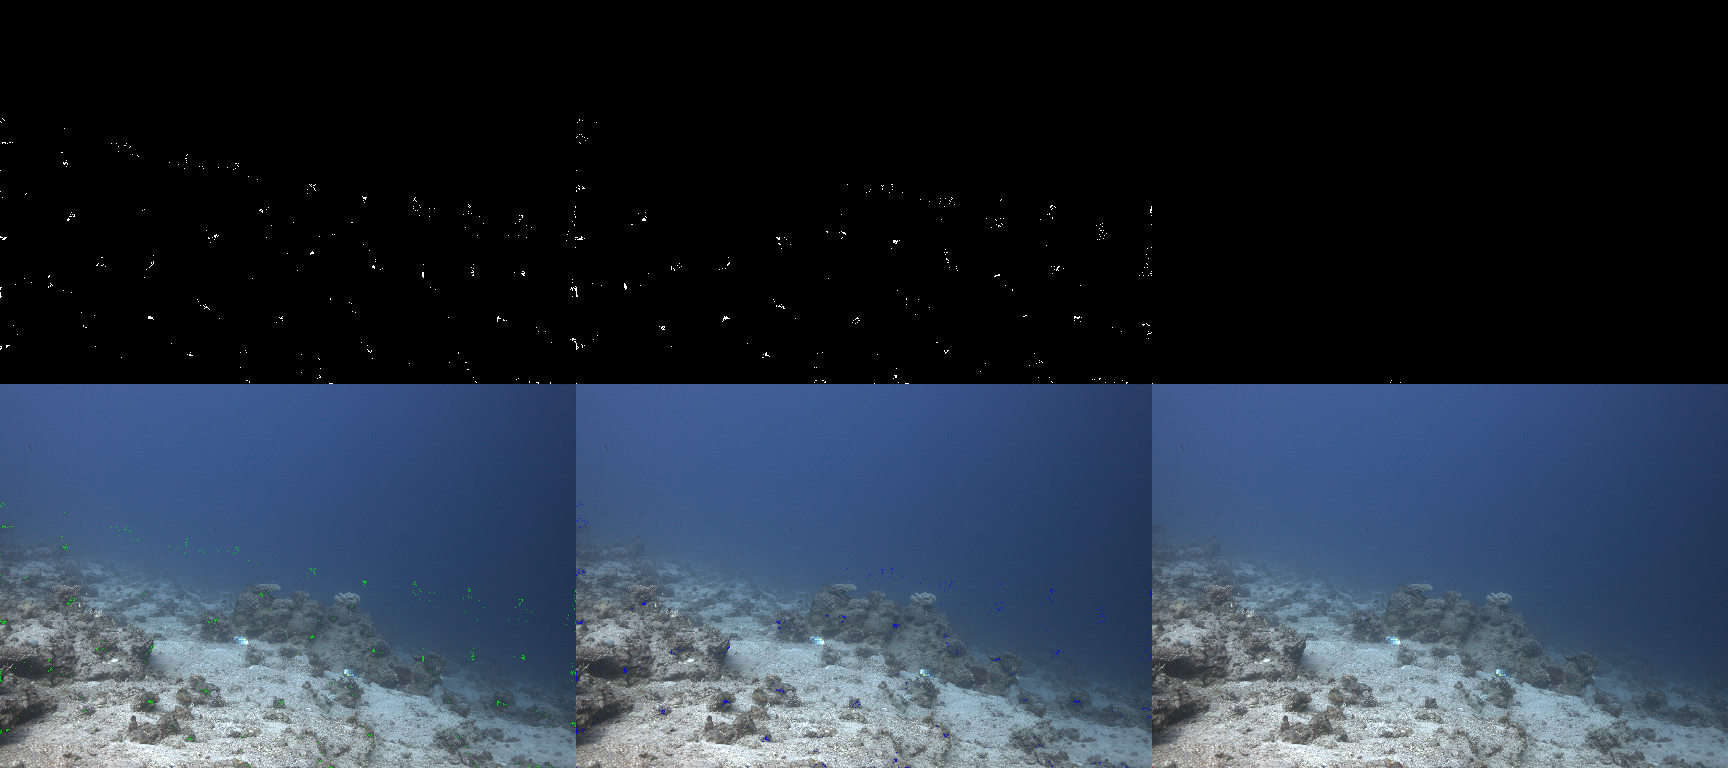

In [524]:
# plot I vs d_D plots on the same graph
import matplotlib.pyplot as plt
from Pude_training_loop.loss_functions import get_medium_transmission_vectorized
def produce_images_and_plots(W,H, raw_image, d_D, I, M, hat_nu, hat_mu, hat_B_infty):
    M_mask_green = np.zeros(W*H, dtype=bool)
    M_mask_green[M[0,:]] = True
    M_mask_green = M_mask_green.reshape(W, H)
    M_mask_blue = np.zeros(W*H, dtype=bool)
    M_mask_blue[M[1,:]] = True
    M_mask_blue = M_mask_blue.reshape(W, H)

    display(raw_image)

    plt.figure(figsize=(10, 6))
    plt.scatter(d_D[0, M[0]], I[0, M[0]], c='g', label='G')
    plt.scatter(d_D[1, M[1]], I[1, M[1]], c='b', label='B')
    
    # find the outliers in d_D[1, M[1]]  and I[1, M[1]] 
    # linear regression to find the outliers
    lingress = np.polyfit(d_D[1, M[1]], I[1, M[1]], 1)
    # find the residuals
 
    residuals = I[1, M[1]] - (lingress[0]*d_D[1, M[1]] + lingress[1])
    # find the outliers
    outliers = np.where(residuals > 0.1)

    # create l
    x_vals = np.linspace(np.min(d_D), np.max(d_D), 800)
    pred_I = hat_B_infty[:, np.newaxis] * (1-get_medium_transmission_vectorized(x_vals, hat_nu, hat_mu))
    # 
    plt.plot(x_vals, pred_I[0], c='c', label='Fitted green channel')
    plt.plot(x_vals, pred_I[1], c='m', label='Fitted blue channel')

    # plot the outliers in red
    plt.scatter(d_D[1, M[1][outliers]], I[1, M[1][outliers]], c='r', label='Outliers')
    plt.xlabel('d_D')
    plt.ylabel('I')
    plt.legend()
    plt.show()

    # create a new mask for the outliers
    outliers_mask = np.zeros(W*H, dtype=bool)
    outliers_mask[M[1][outliers]] = True
    outliers_mask = outliers_mask.reshape(W, H)
    masks = [M_mask_green, M_mask_blue, outliers_mask]
    mask_colors = [(0,1,0), (0,0,1), (1,0,0)]
    mask_images = [return_mask_as_image(mask) for mask in masks]
    applied_masks = [Image.fromarray(overlay_color(np.array(raw_image), mask=mask, color=color, alpha=0.7)) for mask, color in zip(masks, mask_colors)]
    all_images = mask_images + applied_masks
    display(make_image_grid(all_images, rows=2, cols=3))
  
N_1 = 500
N_2 = 200


# get G,B from raw_image
I  = np.array([np.array(raw_image.getchannel('G')).flatten(), np.array(raw_image.getchannel('B')).flatten()])/255.0


d_D = model_output.flatten()
d_D  = np.array([d_D, d_D])
hat_nu, hat_mu, hat_B_infty, darkest_indices, M = find_underwater_parameters(d_D, I, N=N_1, M_range=(5,95), 
                                                                               cluster_size=5) 
                                                            
print("Optimized Parameters:")
print("hat_nu:", hat_nu)
print("hat_mu:", hat_mu)
print("hat_B_infty:", hat_B_infty)

produce_images_and_plots(default_image_dim[1], default_image_dim[0], raw_image, d_D, I, M, hat_nu, hat_mu, hat_B_infty)

# set 


# print(d_D.shape, I.shape)

# hat_nu, hat_mu, hat_B_infty, darkest_indices, M = find_underwater_parameters(d_D, I, N=N_2, initial_v=hat_nu, initial_mu=hat_mu, 
#                                                          initial_B_infty=hat_B_infty, keep_B_infty=True)
                                                
# print("2nd run Optimized Parameters:")
# print("hat_nu:", hat_nu)
# print("hat_mu:", hat_mu)
# print("hat_B_infty:", hat_B_infty)

# produce_images_and_plots(default_image_dim[1], default_image_dim[0], raw_image, d_D, I, darkest_indices, M)


# img = np.array(raw_image)
# display(Image.fromarray(overlay_color(np.array(raw_image), mask=darkest_mask, color=(0, 0, 1), alpha=0.5)))
# overlay_color(img, mask=M_mask_blue, color=(0,0,1), alpha=0.5)
# display(Image.fromarray(overlay_color(img, mask=M_mask_green, color=(0,1, 0), alpha=1)))


(2, 221184)
[0.18235563 0.01716418]
(2, 221184)
False


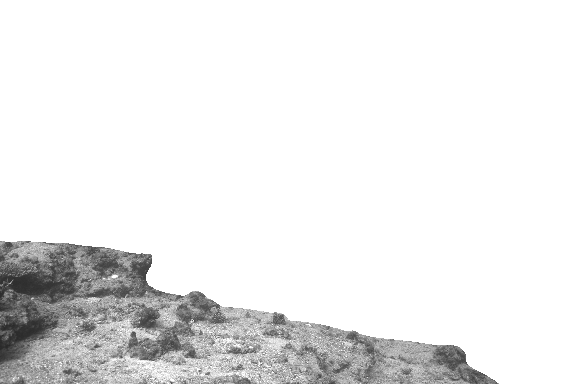

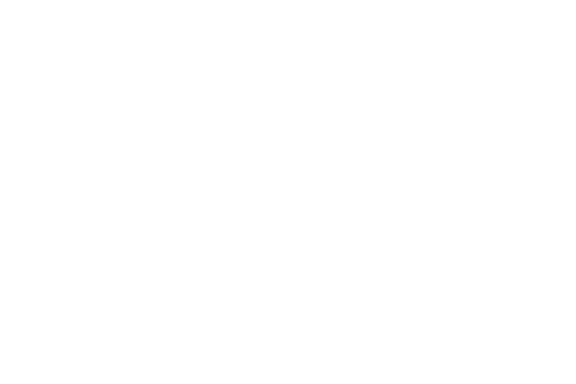

Altering params for channel: 0, selected: 76/200
percentile_h: 1, percentile_l: 98, cluster_radius: 40, cluster_size: 2
Altering params for channel: 0, selected: 76/200
Increasing Cluster size
percentile_h: 1, percentile_l: 98, cluster_radius: 40, cluster_size: 4
Altering params for channel: 0, selected: 124/200
Increasing Cluster size
percentile_h: 1, percentile_l: 98, cluster_radius: 40, cluster_size: 6
Altering params for channel: 0, selected: 171/200
Increasing Cluster size
percentile_h: 1, percentile_l: 98, cluster_radius: 40, cluster_size: 8
Altering params for channel: 0, selected: 195/200
Increasing Cluster size
Decreasing cluster max radial
percentile_h: 1, percentile_l: 98, cluster_radius: 36, cluster_size: 8
Altering params for channel: 0, selected: 190/200
Increasing Cluster size
Decreasing cluster max radial
percentile_h: 1, percentile_l: 98, cluster_radius: 32, cluster_size: 8
Altering params for channel: 0, selected: 188/200
Increasing Cluster size
Decreasing cluster max

IndexError: index -1 is out of bounds for axis 0 with size 0

In [525]:
def get_tau_threshold(x: np.ndarray, a: float = 0.7, b: float=1) -> np.ndarray:
    """
    calculates tau threshold based on calcualted nu for each channel
    x: nu 
    Evaluate the function f(x) = (-x) / (x + a) + 1 for vectors x and a.
    
    Parameters:
        x (Union[float, np.ndarray]): Input vector.
        a (Union[float, np.ndarray]): Parameter a.
    
    Returns:
        np.ndarray: Output vector.
    """
    return ((-b*x) / (x + a) )+ 1

tau = get_medium_transmission_vectorized(d_D, hat_nu, hat_mu)
# find where tau is greater than 0.2
print(tau.shape)
tau_thresholds = get_tau_threshold(hat_nu)
# create a mask for each channel using tau_threshold
tau_max_thresholds = get_tau_threshold(hat_nu, a=10, b =1.01)
print(tau_max_thresholds)
tau_mask =  (tau[:,]<tau_thresholds[:, np.newaxis]) | (tau[:,]>tau_max_thresholds[:, np.newaxis])
print(tau_mask.shape)
t =tau.shape[1] - np.sum(tau_mask, axis=1)
t_test = np.sum((t-N_2)>=0)
print( t_test>=tau.shape[0])
I_new = I.copy()
I_new[tau_mask] = 1.0
d_D_new = d_D.copy()
d_D_new[tau_mask] = 0.0
display((Image.fromarray((I_new[0].reshape(default_image_dim[1], default_image_dim[0])*255.0).astype(np.uint8))))
display((Image.fromarray((I_new[1].reshape(default_image_dim[1], default_image_dim[0])*255.0).astype(np.uint8))))
# set 


# print(d_D.shape, I.shape)

hat_nu2, hat_mu2, hat_B_infty2, darkest_indices, M = find_underwater_parameters(d_D_new, I_new, N=N_2, initial_v=hat_nu, initial_mu=hat_mu, 
                                                          initial_B_infty=hat_B_infty, keep_B_infty=True, M_range=(0,100), 
                                                          cluster_radius=40, cluster_size=2, is_verbose=True)
                                                
print("2nd run Optimized Parameters:")
print("hat_nu:", hat_nu2)
print("hat_mu:", hat_mu2)
print("hat_B_infty:", hat_B_infty2)

produce_images_and_plots(default_image_dim[1], default_image_dim[0], raw_image, d_D, I, M, hat_nu2, hat_mu2, hat_B_infty2)


# img = np.array(raw_image)
# display(Image.fromarray(overlay_color(np.array(raw_image), mask=darkest_mask, color=(0, 0, 1), alpha=0.5)))
# overlay_color(img, mask=M_mask_blue, color=(0,0,1), alpha=0.5)
# display(Image.fromarray(overlay_color(img, mask=M_mask_green, color=(0,1, 0), alpha=1)))

In [ ]:
# alg 2 implementation
seed = 42
np.random.seed(seed)

def find_set_M_random(I, d_D, N, default_image_dim=(576, 384)):
    num_channels = I.shape[0]
    reshaped_I = I.reshape(num_channels, default_image_dim[1], default_image_dim[0])
    selected_indices = []
    

    for channel in range(num_channels):
        # select N random points
        selected_indices_channel = np.random.choice(reshaped_I.shape[1]*reshaped_I.shape[2], N, replace=False)
        # get N/2 darkest indices
        sorted_indices = np.argsort(reshaped_I[channel].flatten())
    return np.array(selected_indices)

In [25]:
import numpy as np

# Creating  a n by n grid with numbers as its index
n = 5
image = np.arange(n*n).reshape(n, n)
print(image)

import numpy as np
from typing import Tuple, List

def flattened_index_to_2d(flattened_index: int, num_columns: int) -> Tuple[int, int]:
    """
    Convert a flattened index to its corresponding 2D indices.

    Args:
        flattened_index (int): The flattened index.
        num_columns (int): The number of columns in the 2D array.

    Returns:
        Tuple[int, int]: The row and column indices in the 2D array.
    """
    row_index = flattened_index // num_columns
    column_index = flattened_index % num_columns
    return row_index, column_index

def flattened_indices_to_2d(flattened_indices: np.ndarray, num_columns: int) -> np.ndarray:
    """
    Convert a NumPy array of flattened indices to their corresponding 2D indices.

    Args:
        flattened_indices (np.ndarray): The NumPy array of flattened indices.
        num_columns (int): The number of columns in the 2D array.

    Returns:
        np.ndarray: A NumPy array of row and column indices in the 2D array.
    """
    row_indices = flattened_indices // num_columns
    column_indices = flattened_indices % num_columns
    return np.column_stack((row_indices, column_indices))


def two_d_index_to_flattened(row_index: int, column_index: int, num_columns: int) -> int:
    """
    Convert 2D indices to a flattened index.

    Args:
        row_index (int): The row index in the 2D array.
        column_index (int): The column index in the 2D array.
        num_columns (int): The number of columns in the 2D array.

    Returns:
        int: The flattened index.
    """
    return row_index * num_columns + column_index


def get_indices_within_radius(flattened_index: int, radius: int, num_rows: int, num_columns: int) -> List[int]:
    """
    Get the indices of points within a given radius of a flattened index in a 2D array.

    Args:
        flattened_index (int): The flattened index.
        radius (int): The radius around the index to search for points.
        num_rows (int): The number of rows in the 2D array.
        num_columns (int): The number of columns in the 2D array.

    Returns:
        List[int]: The indices of points within the specified radius.
    """
    row_index, column_index = flattened_index_to_2d(flattened_index, num_columns)
    
    # Calculate the valid range of rows and columns
    start_row = max(0, row_index - radius)
    end_row = min(num_rows - 1, row_index + radius)
    start_col = max(0, column_index - radius)
    end_col = min(num_columns - 1, column_index + radius)
    
    # Generate a grid of row and column indices within the valid range
    rows = np.arange(start_row, end_row + 1).reshape(-1, 1)
    cols = np.arange(start_col, end_col + 1).reshape(1, -1)
    
    # Calculate the distance from the center index for each index in the grid
    distances = np.abs(rows - row_index) + np.abs(cols - column_index)
    
    # Filter out indices that are within the specified radius
    indices_within_radius = (distances <= radius) * (rows * num_columns + cols)
    
    return indices_within_radius[indices_within_radius != 0].flatten().tolist()


def np_get_indices_within_radius(flattened_indices: np.ndarray, radius: int, num_rows: int, num_columns: int) -> np.ndarray:
    """
    Get the indices of points within a given radius of each flattened index in a 2D array.

    Args:
        flattened_indices (np.ndarray): The array of flattened indices.
        radius (int): The radius around each index to search for points.
        num_rows (int): The number of rows in the 2D array.
        num_columns (int): The number of columns in the 2D array.

    Returns:
        np.ndarray: The indices of points within the specified radius for each input index.
    """
    # Convert flattened indices to 2D indices
    row_indices = flattened_indices // num_columns
    column_indices = flattened_indices % num_columns
    
    # Generate grid of row and column indices within the search range
    # rows = np.arange(num_rows).reshape(-1, 1)
    # cols = np.arange(num_columns).reshape(1, -1)
    
    # Calculate the distance from each index to all points in the grid
    distances = np.abs(num_rows - row_indices[:, None]) + np.abs(num_columns - column_indices[:, None])
    
    # Mask indices within the specified radius
    indices_within_radius = np.where(distances <= radius,  * num_columns + cols, 0)
    
    # Flatten and filter out zero values (outside the radius)
    return indices_within_radius[indices_within_radius != 0]

def get_random_indices(num_samples: int, N: int) -> list:
    """
    Get N random indices between 0 and num_samples (exclusive).

    Args:
        num_samples (int): The maximum value (exclusive) for random indices.
        N (int): The number of random indices to generate.

    Returns:
        list: N random indices between 0 and num_samples (exclusive).
    """
    return np.random.choice(range(num_samples), size=N, replace=False)

# Test get_indices_within_radius
flattened_index = 4
radius = 2
num_rows = 5
num_columns = 5
indices_within_radius = get_indices_within_radius(flattened_index, radius, num_rows, num_columns)
print(indices_within_radius)


# Test get_indices_within_radius
flattened_index = 4
print()
radius = 2
num_rows = image.shape[0]
num_columns = image.shape[1]
indices_within_radius = get_indices_within_radius(flattened_index, radius, num_rows, num_columns)
print(indices_within_radius)

# Test np_get_indices_within_radius

random_indices = get_random_indices(25, [2,3])
print(random_indices)

# Test np_get_indices_within_radius
indices_within_radius = np_get_indices_within_radius(flattened_indices=random_indices[0], 
                                                     radius=2, num_rows=5, num_columns=5)
print(indices_within_radius)


[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
[2, 3, 4, 8, 9, 14]

[2, 3, 4, 8, 9, 14]
[[22 11  6]
 [23 17  4]]


NameError: name 'rows' is not defined

In [22]:
import heapq


class IndexHeap:
    def __init__(self, I, indices):
        self.I = I
        self.heap = self.create_heap_with_indices(indices)
    def create_heap_with_indices(self, indices):
        # Create a heap with custom comparator
        heapq.heapify(indices, key=lambda x: self.I[x])
        return indices
    def merge_heaps(self, heap1, heap2):
        # Merge two heaps into a single heap
        merged_heap = heap1 + heap2
        heapq.heapify(merged_heap, key=lambda x: self.I[x])
        return merged_heap
    def pop_k_indices(self, heap, k):
        # Pop k indices from the heap
        popped_indices = []
        for _ in range(k):
            if heap:
                popped_indices.append(heapq.heappop(heap))
        return popped_indices
    def push_index(self, heap, index, value):
        # Push a new index into the heap
        heapq.heappush(heap, index)
        # Rebuild the heap with the updated key function
        heapq.heapify(heap, key=lambda x: self.I[x])
    def get_top_index(self, heap):
        # Get the index with the minimum value from the heap
        if heap:
            return heap[0]
        return None
    
def find_set_M_new(I, d, N):
    # get first set of random indices of I
    num_channels = I.shape[0]
    # get 50% of N random indices
    k = int(np.ceil(0.5*N))
    selected_indices = [[], []]
    random_indices = get_random_indices(I.shape[1], [I.shape[0], k])
    index_heap = IndexHeap(I, random_indices)
    while len(selected_indices[0])<N and len(selected_indices[1])<N:
        for channel in range(num_channels):
            # get the random indices for the channel
            random_indices = get_random_indices(I.shape[1], k)
            # get the N/2 darkest indices
            sorted_indices = np.argsort(I[channel, random_indices])
            selected_indices[channel] = random_indices[sorted_indices[:N]]






[[10  9  0]
 [20 16  6]]
[[[2 0]
  [1 4]
  [0 0]]

 [[4 0]
  [3 1]
  [1 1]]]


In [162]:
import torch
from typing import Tuple, List

import torch
from typing import List

def flattened_index_to_2d(flattened_index: torch.Tensor, num_columns: int) -> torch.Tensor:
    """
    Convert a tensor of flattened indexes to their corresponding 2D indices.

    Args:
        flattened_index (torch.Tensor): A tensor of flattened indexes.
        num_columns (int): The number of columns in the 2D array.

    Returns:
        torch.Tensor: A tensor containing row and column indices in the 2D array.
    """
    row_index = flattened_index // num_columns
    column_index = flattened_index % num_columns
    return torch.stack((row_index, column_index), dim=1)



def get_indices_within_radius(flattened_index: torch.Tensor, radius: int, num_rows: int, num_columns: int) -> torch.Tensor:
    """
    Get the indices of points within a given radius of flattened indexes in a 2D array.

    Args:
        flattened_index (torch.Tensor): A tensor of flattened indexes.
        radius (int): The radius around each index to search for points.
        num_rows (int): The number of rows in the 2D array.
        num_columns (int): The number of columns in the 2D array.

    Returns:
        torch.Tensor: A tensor containing the indices of points within the specified radius.
    """
    def _get_unique_coordinates(coordinates: torch.Tensor, radius: float) -> torch.Tensor:
        """
        Get unique coordinates using a mask-based approach.

        Args:
            coordinates (torch.Tensor): A tensor of 2D coordinates (x, y).
            radius (float): The minimum allowed distance between coordinates.

        Returns:
            torch.Tensor: A tensor containing unique coordinates satisfying the conditions.
        """
        print("coord", coordinates)
        mask = torch.zeros(len(coordinates), dtype=torch.bool)
        for i, coord in enumerate(coordinates):
            print("coord", coord - coordinates[mask].flatten(), coordinates[mask].flatten())
            if not mask[:i].any() or torch.all(torch.norm(coord - coordinates[mask].flatten(), dim=1) >= radius):
                mask[i] = True
        return coordinates[mask]

    def _get_indices_within_radius(start_row, end_row, start_col, end_col, row_index, column_index) -> torch.Tensor:
        rows = torch.arange(start_row, end_row + 1).unsqueeze(1)
        cols = torch.arange(start_col, end_col + 1).unsqueeze(0)
        distances = torch.abs(rows - row_index) + torch.abs(cols - column_index)
        indices_within_radius = (distances <= radius) * (rows * num_columns + cols)
        return indices_within_radius[indices_within_radius != 0].flatten()


    indexes = flattened_index_to_2d(flattened_index, num_columns)
    print(indexes.shape)
    # remove indexes which are within the radius of each other
    indexes = _get_unique_coordinates(indexes, radius)
    print(indexes)




    # Calculate the valid range of rows and columns
    start_rows = torch.clamp(indexes[:, 0] - radius, min=0)
    end_rows = torch.clamp(indexes[:, 0] + radius, max=num_rows - 1)
    start_cols = torch.clamp(indexes[:, 1] - radius, min=0)
    end_cols = torch.clamp(indexes[:, 1] + radius, max=num_columns - 1)

    for i in range(len(flattened_index)):
        start_row = start_rows[i]
        end_row = end_rows[i]
        start_col = start_cols[i]
        end_col = end_cols[i]
        row_index = indexes[i, 0]
        col_index = indexes[i, 1]
        indices_within_radius = _get_indices_within_radius(start_row, end_row, start_col, end_col, row_index, col_index)
        if i == 0:
            result = indices_within_radius
        else:
            result = torch.cat((result, indices_within_radius), dim=-1)

    result = torch.unique(result)
    print(result)
    return result




n = 10
image = np.arange(n*n).reshape(n, n)
print(image)
# Test get_indices_within_radius
N = 5
# select N random indices from the image
selected_indices = torch.randint(0, image.shape[0]*image.shape[1], (N,))
print(selected_indices)
# select all points within a radius of selected indices
radius = 2
indices_within_radius = get_indices_within_radius(selected_indices, radius, image.shape[0], image.shape[1])
print(indices_within_radius.shape)
# flattened_index = 4
# radius = 2
# num_rows = 5
# num_columns = 5
# indices_within_radius = get_indices_within_radius(flattened_index, radius, num_rows, num_columns)
# print(indices_within_radius)


[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]
tensor([21, 19, 16, 81, 90])
torch.Size([5, 2])
coord tensor([[2, 1],
        [1, 9],
        [1, 6],
        [8, 1],
        [9, 0]])
coord tensor([], size=(0, 2), dtype=torch.int64) tensor([], dtype=torch.int64)
coord tensor([[-1,  8]]) tensor([2, 1])


RuntimeError: linalg.vector_norm: Expected a floating point or complex tensor as input. Got Long

In [150]:
import torch
import timeit

def get_unique_coordinates_list(coordinates: torch.Tensor, radius: float) -> torch.Tensor:
    """
    Get unique coordinates using a list-based approach.

    Args:
        coordinates (torch.Tensor): A tensor of 2D coordinates (x, y).
        radius (float): The minimum allowed distance between coordinates.

    Returns:
        torch.Tensor: A tensor containing unique coordinates satisfying the conditions.
    """
    selected_coordinates = []
    for coord in coordinates:
        if not any(torch.norm(coord - selected_coord) < radius for selected_coord in selected_coordinates):
            selected_coordinates.append(coord)
    return torch.stack(selected_coordinates)

def get_unique_coordinates_mask(coordinates: torch.Tensor, radius: float) -> torch.Tensor:
    """
    Get unique coordinates using a mask-based approach.

    Args:
        coordinates (torch.Tensor): A tensor of 2D coordinates (x, y).
        radius (float): The minimum allowed distance between coordinates.

    Returns:
        torch.Tensor: A tensor containing unique coordinates satisfying the conditions.
    """
    mask = torch.zeros(len(coordinates), dtype=torch.bool)
    for i, coord in enumerate(coordinates):
        if not mask[:i].any() or torch.all(torch.norm(coord - coordinates[:i][mask[:i]], dim=1) >= radius):
            mask[i] = True
    return coordinates[mask]

# Generate random 2D coordinates
torch.manual_seed(0)
coordinates = torch.rand(10, 2)
print(coordinates)

# Set the radius
radius = 0.1

# Time the list-based implementation
time_list = timeit.timeit(lambda: get_unique_coordinates_list(coordinates, radius), number=1)

# Time the mask-based implementation
time_mask = timeit.timeit(lambda: get_unique_coordinates_mask(coordinates, radius), number=1)

print("Time taken by list-based implementation:", time_list)
print("Time taken by mask-based implementation:", time_mask)


tensor([[0.4963, 0.7682],
        [0.0885, 0.1320],
        [0.3074, 0.6341],
        [0.4901, 0.8964],
        [0.4556, 0.6323],
        [0.3489, 0.4017],
        [0.0223, 0.1689],
        [0.2939, 0.5185],
        [0.6977, 0.8000],
        [0.1610, 0.2823]])
Time taken by list-based implementation: 0.004103800001757918
Time taken by mask-based implementation: 0.002062299998215167


Increasing distance range 0 478
Increasing distance range 0 492
Increasing distance range 1 498
(2, 500)


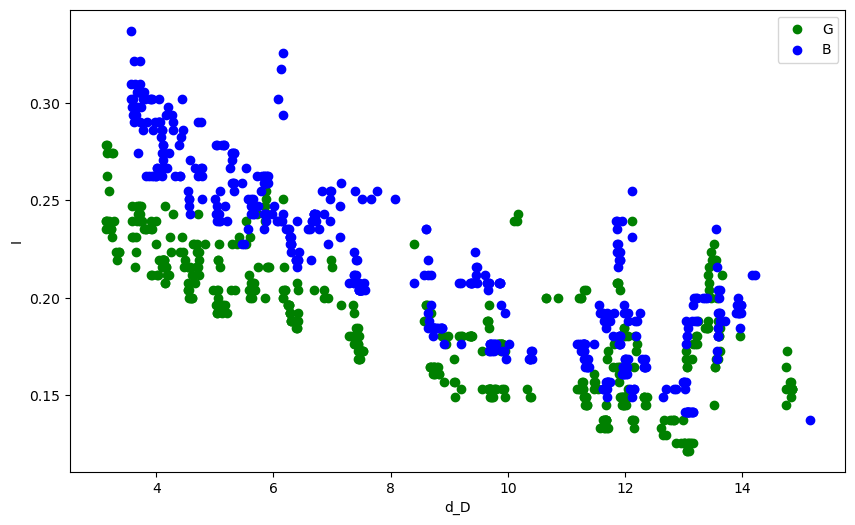

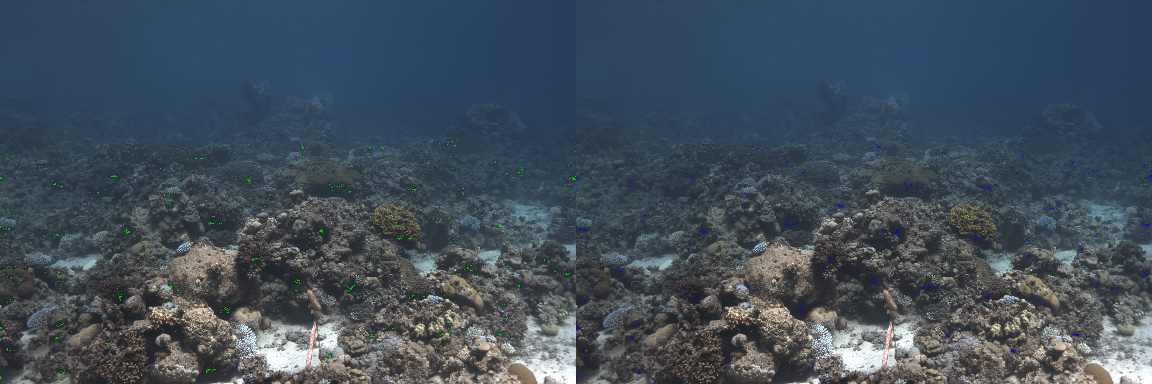

In [242]:


def produce_images_and_plots(W, H, raw_image, d_D, I, M):
    # create masks for the M set
    M_mask_green = np.zeros(W*H, dtype=bool)
    M_mask_green[M[0,:]] = True
    M_mask_green = M_mask_green.reshape(W, H)
    M_mask_blue = np.zeros(W*H, dtype=bool)
    M_mask_blue[M[1,:]] = True
    M_mask_blue = M_mask_blue.reshape(W, H)

    # Plot M set
    plt.figure(figsize=(10, 6))
    plt.scatter(d_D[0, M[0]], I[0, M[0]], c='g', label='G')
    plt.scatter(d_D[1, M[1]], I[1, M[1]], c='b', label='B')
    plt.xlabel('d_D')
    plt.ylabel('I')
    plt.legend()
    plt.show()

    # Display images
    mask_colors = [(0,1,0), (0,0,1)]
    masks = [M_mask_green, M_mask_blue]
    mask_images = [Image.fromarray(overlay_color(np.array(raw_image), mask=mask, color=color, alpha=0.7)) for mask, color in zip(masks, mask_colors)]
    display(make_image_grid(mask_images, rows=1, cols=2))

M = find_set_M(I.reshape(2, W, H), d_D.reshape(2,W,H), N_1)
print(M.shape)
produce_images_and_plots(default_image_dim[1], default_image_dim[0], raw_image, d_D, I, M)



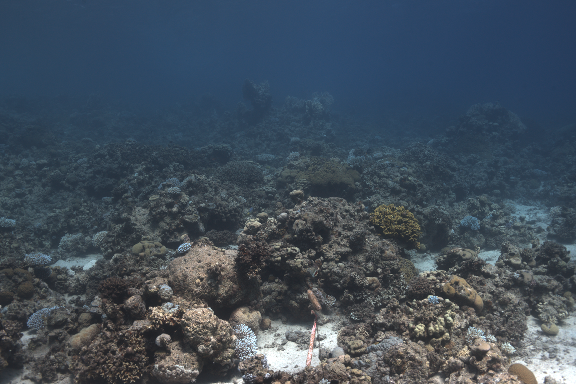

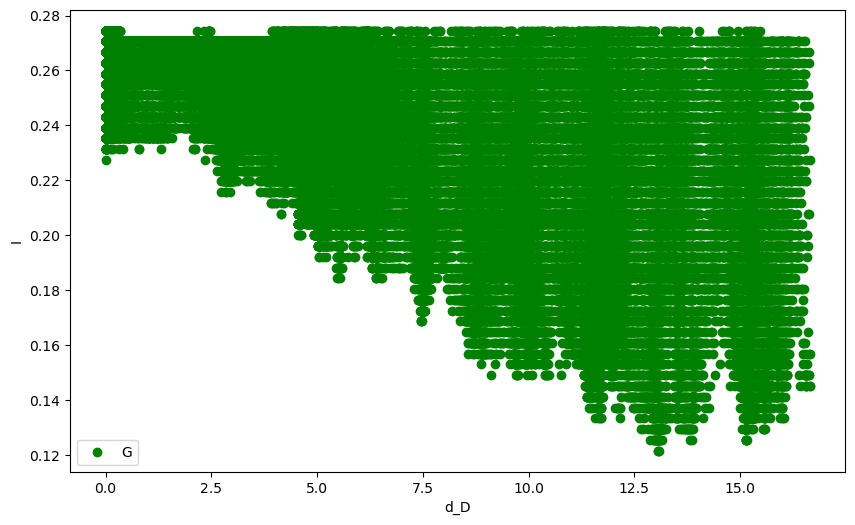

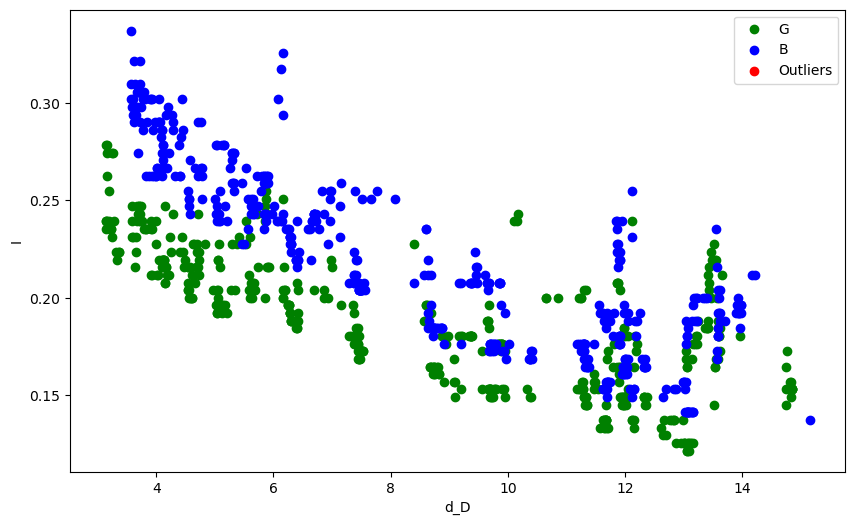

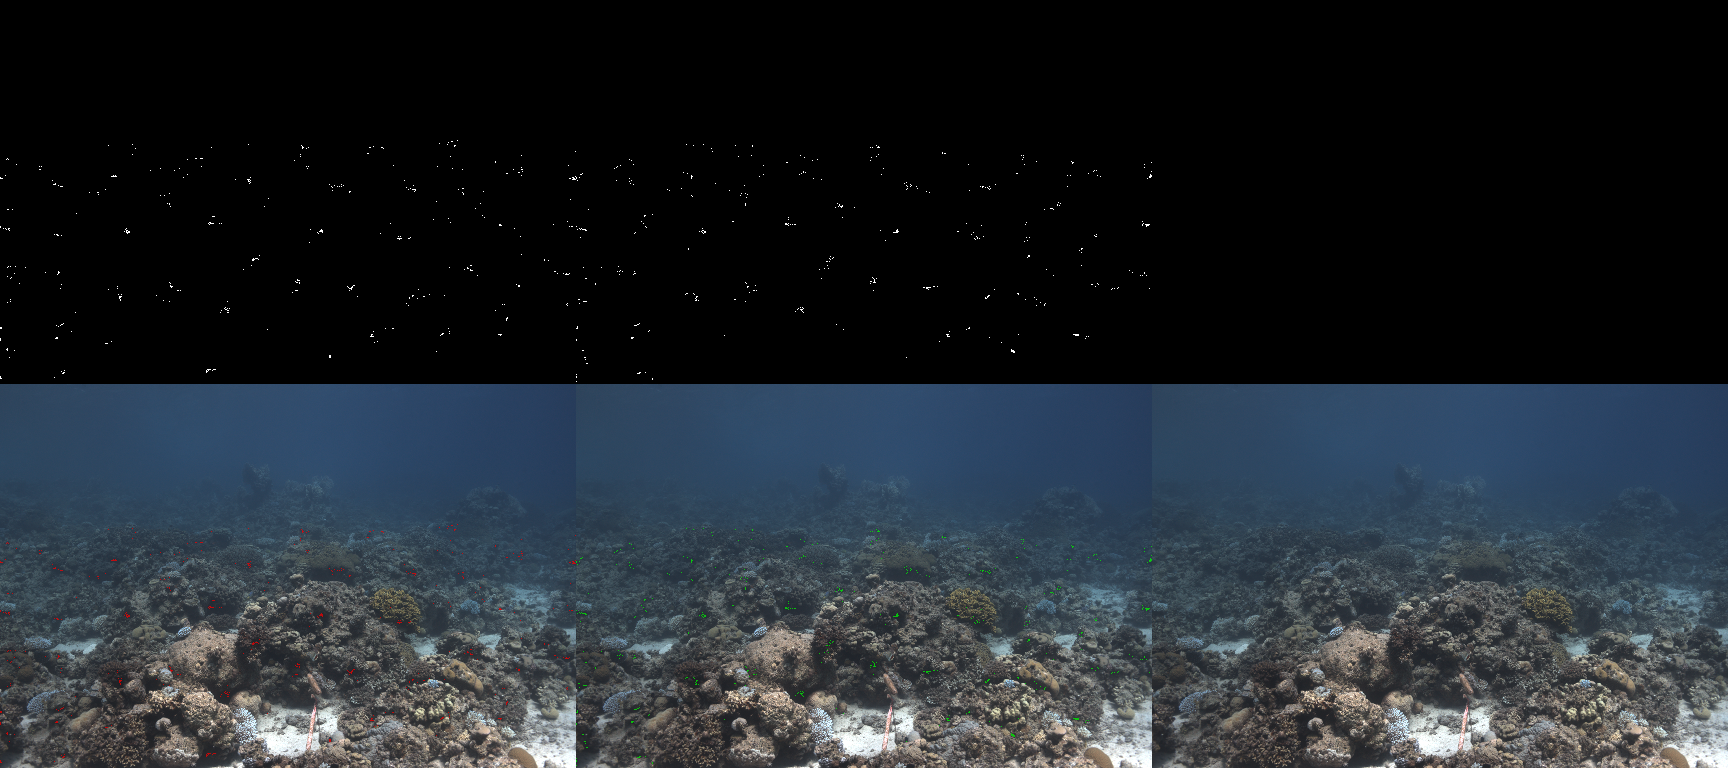

In [264]:


produce_images_and_plots(default_image_dim[1], default_image_dim[0], raw_image, d_D, I, M)



    
    
    

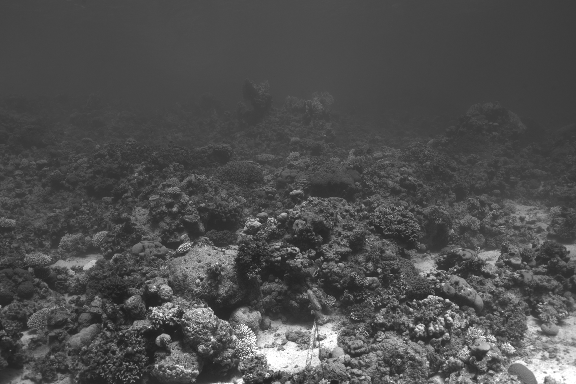

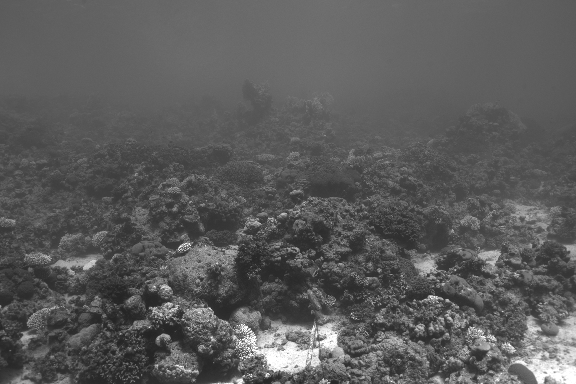

(384, 576)


IndexError: index 574 is out of bounds for axis 0 with size 384

In [114]:
I  = np.array([np.array(raw_image.getchannel('G')).flatten(), np.array(raw_image.getchannel('B')).flatten()])/255.0

I_reshaped = I.reshape(2, W, H)
im = Image.fromarray((I_reshaped[0]*255).astype(np.uint8)).convert("RGB")
display(im)
im = Image.fromarray((I_reshaped[1]*255).astype(np.uint8)).convert("RGB")
display(im)
sorted_indices = np.argsort(I_reshaped[0])
print(sorted_indices.shape)
# create a mask for the darkest points
darkest_mask = np.zeros((W, H), dtype=bool)
darkest_mask[sorted_indices[:N_1, :N_1]] = True

display_mask_as_image(darkest_mask)


In [81]:
import numpy as np
from typing import List
import torch
# Given array
x = np.array([[[0, 10], [30, 4] , [6, 7 ]], [[1, 10], [30, 4] , [6, 7 ]]]).reshape(2,-1)
y = np.array([[1, 20]]).reshape(2,-1)
print(x.shape, y.shape)
z = x >=6
print(z)
print(x)
M_mask = torch.tensor(z)
# find number of elements greater than 6
t_hat_D = torch.tensor(x*0.1)
t_hat_P = torch.tensor(x*0.1)
B_infty = torch.tensor(y*0.1)
I = torch.tensor(x)
print("tens",I>=6)
# print(t_hat_D)
print(np.sum(z))
M_mask_nums = torch.sum(M_mask, dim=1)
def compute_lu_loss_torch(I: torch.Tensor, t_hat_D: torch.Tensor, t_hat_P: torch.Tensor, B_infty: torch.Tensor, n_valid_points: torch.Tensor) -> torch.Tensor:
        """
        Compute upper bound loss function.

        Parameters:
            I (torch.Tensor]): Input image tensor of shape (channels, npoints).
            t_hat_D (torch.Tensor]): Predicted dehazed medium transmission tensor of shape (channels, npoints).
            t_hat_P (torch.Tensor]): Predicted medium transmission tensor of shape (channels, npoints).
            B_infty (torch.Tensor): Predicted background light tensor of shape (channels,).
            n_valid_points (torch.Tensor): Number of valid points tensor of shape (channels,).

        Returns:
            torch.Tensor: the loss value
        """
        # Compute the intermediate expressions
        loss_lu = 0
        for c in range(len(I)):
            intermediate_lu = - (1-t_hat_P[c]) * B_infty[c] - t_hat_D[c] + I[c]
            loss_lu += torch.sum(torch.relu(intermediate_lu))/n_valid_points[c]
        return loss_lu
def compute_lu_loss_torch_v(I: torch.Tensor, t_hat_D: torch.Tensor, t_hat_P: torch.Tensor, B_infty: torch.Tensor, n_valid_points: torch.Tensor) -> torch.Tensor:
    """
    Compute upper bound loss function.

    Parameters:
        I (torch.Tensor]): Input image tensor of shape (channels, npoints).
        t_hat_D (torch.Tensor]): Predicted dehazed medium transmission tensor of shape (channels, npoints).
        t_hat_P (torch.Tensor]): Predicted medium transmission tensor of shape (channels, npoints).
        B_infty (torch.Tensor): Predicted background light tensor of shape (channels,).
        n_valid_points (torch.Tensor): Number of valid points tensor of shape (channels,).
    Returns:
        torch.Tensor: the loss value
    """
    # Compute the intermediate expressions
    intermediate_lu = - (1 - t_hat_P) * B_infty - t_hat_D + I
    # Sum over channels
    loss_lu = torch.sum(torch.sum(torch.relu(intermediate_lu), dim=1) / n_valid_points)
    return loss_lu
I_nums = torch.tensor([I.shape[1]]*I.shape[0])
print(compute_lu_loss_torch(I, t_hat_D, t_hat_P, B_infty, I_nums))
print(compute_lu_loss_torch(I*M_mask, t_hat_D*M_mask, t_hat_P*M_mask, B_infty, M_mask_nums))
print(compute_lu_loss_torch_v(I, t_hat_D, t_hat_P, B_infty, I_nums))
print(compute_lu_loss_torch_v(I*M_mask, t_hat_D*M_mask, t_hat_P*M_mask, B_infty, M_mask_nums))


def find_M_b_torch(I: torch.Tensor, B_infty_hat: torch.Tensor, t_hat_D: torch.Tensor, gamma: float = 0.6) -> torch.Tensor:
    """
    Find set M_b based on the given condition.

    Parameters:
        I (torch.Tensor): Input image tensor of shape (channels, samples).
        B_infty_hat (torch.Tensor): Predicted background light tensor of shape (channels,).
        t_hat_D (torch.Tensor): Predicted dehazed medium transmission tensor of shape (channels, samples).
        gamma (float): Threshold hyperparameter.

    Returns:
        torch.Tensor: Boolean tensor indicating the set M_b.
    """
    # Compute the expression (B_infty_hat * (1 - t_hat_D)) / I
    expression = (B_infty_hat * (1 - t_hat_D)) / (I+torch.finfo(torch.float32).eps)

    # Apply ReLU to threshold the expression
    print(expression)
    print("exp", expression-gamma)
    M_b_indices = torch.relu(expression - gamma)
    
    # Set values to 1 where expression < gamma
    M_b_indices = 1-torch.relu(1-M_b_indices)

    return M_b_indices

m_mask = find_M_b_torch(I, B_infty, t_hat_D, gamma=0.6)
print(m_mask, M_mask)
print(M_mask.shape)
print(m_mask.shape)
print(torch.sum(m_mask, dim=1))

(2, 6) (2, 1)
[[False  True  True False  True  True]
 [False  True  True False  True  True]]
[[ 0 10 30  4  6  7]
 [ 1 10 30  4  6  7]]
tens tensor([[False,  True,  True, False,  True,  True],
        [False,  True,  True, False,  True,  True]])
8
tensor(17.3450, dtype=torch.float64)
tensor(24.5325, dtype=torch.float64)
tensor(17.3450, dtype=torch.float64)
tensor(24.5325, dtype=torch.float64)
tensor([[ 8.3886e+05,  0.0000e+00, -6.6667e-03,  1.5000e-02,  6.6667e-03,
          4.2857e-03],
        [ 1.8000e+00,  0.0000e+00, -1.3333e-01,  3.0000e-01,  1.3333e-01,
          8.5714e-02]], dtype=torch.float64)
exp tensor([[ 8.3886e+05, -6.0000e-01, -6.0667e-01, -5.8500e-01, -5.9333e-01,
         -5.9571e-01],
        [ 1.2000e+00, -6.0000e-01, -7.3333e-01, -3.0000e-01, -4.6667e-01,
         -5.1429e-01]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.]], dtype=torch.float64) tensor([[False,  True,  True, False,  True,  True],
        [False,  True,  Tr

In [ ]:
import numpy as np

def get_medium_transmission_vectorized(d_D, nu, mu):
    """
    Compute medium transmission for each channel across all samples using vectorized operations.

    Parameters:
        d_D (numpy.ndarray): Array of size (samples,) containing depth values.
        nu (numpy.ndarray): Array of size (channels,) containing nu values.
        mu (float): Scalar value of mu.

    Returns:
        numpy.ndarray: Array of size (channels, samples) containing medium transmission for each channel.
    """
    # Expand dimensions of nu to match the shape of d_D
    nu_expanded = np.expand_dims(nu, axis=1)  # Shape: (channels, 1)

    # Compute medium transmission for each channel across all samples using vectorized operations
    medium_transmission = np.exp(-nu_expanded / (d_D + mu))

    return medium_transmission


t_hat = get_medium_transmission_vectorized(d_D, hat_nu, hat_mu)

L_bl1: 0.0017228375077411654, L_bl2: 0.04131796425543868, L_bu: 0.003815183193790903
lb: 0.050671168150761656


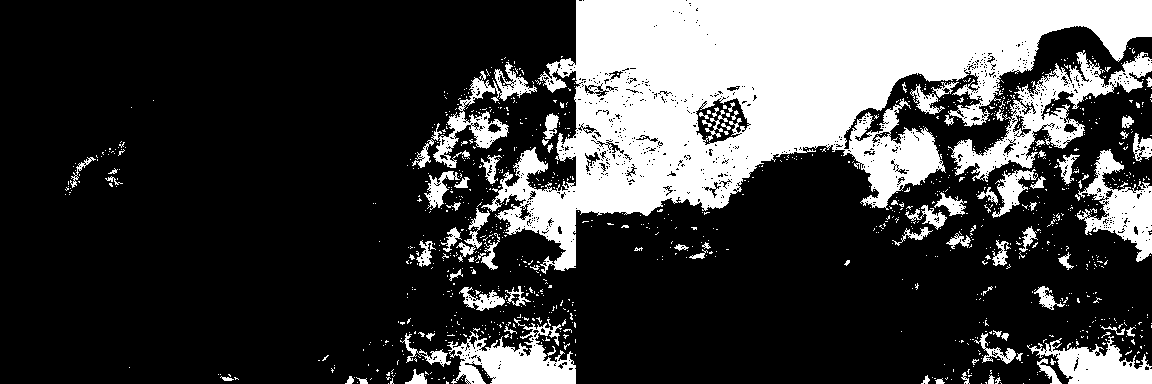

In [155]:
import numpy as np
def compute_lb_loss(I, t_hat, B_infty):
    """
    Compute lower loss function

    Parameters:
        I (numpy.ndarray): Input image array of shape (channels, HW).
        t_hat (numpy.ndarray): Predicted medium transmission array of shape (channels, HW).
        B_infty (numpy.ndarray): Predicted background light array of shape (channels,).

    Returns:
        tuple: numpy.ndarray containing the loss values
    """
    # Compute the intermediate expressions
    intermediate_bl1 = -I + (1 - t_hat) * B_infty[:, np.newaxis]
    intermediate_bl2 = -t_hat - intermediate_bl1

    loss_bl1 = np.sum(np.maximum(intermediate_bl1, 0))/I.shape[1]
    loss_bl2 = np.sum(np.maximum(intermediate_bl2, 0))/I.shape[1]
    
    return loss_bl1, loss_bl2

def compute_lu_loss(I, t_hat_D, t_hat_P, B_infty):
    """
    Compute loss function.

    Parameters:
        I (List[numpy.ndarray]): Input image array of shape (channels, npoints).
        t_hat (List[numpy.ndarray]): Predicted medium transmission array of shape (channels, npoints).
        B_infty (numpy.ndarray): Predicted background light array of shape (channels,).

    Returns:
        tuple: the loss value
    """
    # Compute the intermediate expressions
    loss_lu = 0
    for c in range(len(I)):
        intermediate_lu = - (1-t_hat_P[c]) * B_infty[c] - t_hat_D[c] + I[c]
        loss_lu += np.sum(np.maximum(intermediate_lu, 0))/I[c].shape[0]

    return loss_lu

def find_M_b(I, B_infty_hat, t_hat_D, gamma=0.6):
    """
    Find set M_b based on the given condition.

    Parameters:
        I (numpy.ndarray): Input image array of shape (channels, samples).
        B_infty_hat (numpy.ndarray): Predicted background light array of shape (channels,).
        t_hat_D (numpy.ndarray): Predicted dehazed medium transmission array of shape (channels, samples).
        gamma (float): Threshold hyperparameter.

    Returns:
        numpy.ndarray: Boolean array indicating the set M_b.
    """
    # Compute the expression (B_infty_hat * (1 - t_hat_D)) / I
    expression = (B_infty_hat[:, np.newaxis] * (1 - t_hat_D)) / I

    # Find indices where the expression is greater than or equal to gamma
    M_b_indices = expression >= gamma
    return M_b_indices

def compute_loss_bounds(I, t_hat_P, t_hat_D, B_infty, alphas=[1,1,2], show_MB=False, default_image_dim=(384, 576)):
    """
    Compute bound loss

    Parameters:
        I (numpy.ndarray): Input image array of shape (channels, HW).
        t_hat_P (numpy.ndarray): PuDE Predicted medium transmission array of shape (channels, HW).
        t_hat_D (numpy.ndarray): DPT Predicted medium transmission array of shape (channels, HW).
        B_infty (numpy.ndarray): Predicted background light array of shape (channels,).

    Returns:
        tuple:  the loss values
    """
    
    loss_bl1, loss_bl2 = compute_lb_loss(I, t_hat_P, hat_B_infty)
    M_mask = find_M_b(I, hat_B_infty, t_hat_D)
    I_new = [I[0, M_mask[0]], I[1, M_mask[1]]]
    t_hat_P_new = [t_hat_P[0, M_mask[0]], t_hat_P[1, M_mask[1]]]
    t_hat_D_new = [t_hat_D[0, M_mask[0]], t_hat_D[1, M_mask[1]]]
    loss_bu= compute_lu_loss(I_new, t_hat_D_new, t_hat_P_new, hat_B_infty)

    lb = alphas[0]*loss_bl1 + alphas[1]*loss_bl2 + alphas[2]*loss_bu

    
    if show_MB:
        print(f"L_bl1: {loss_bl1}, L_bl2: {loss_bl2}, L_bu: {loss_bu}")
        print(f"lb: {lb}")
        # print(loss_bl1, loss_bl2, loss_bu)
        images = []
        for i in range(2):
            images.append(return_mask_as_image(M_mask[i].reshape(default_image_dim[1], default_image_dim[0])))
        display(make_image_grid(images, rows=1, cols=2))
    return lb



lb = compute_loss_bounds(I, t_hat, t_hat, hat_B_infty, show_MB=True, default_image_dim=default_image_dim)


In [ ]:
# sea thru nerf
# pixel values  loss
# point selected in estimated steps ( in good positions)
# fitting of the selected points